# 10. 인물사진을 만들어 보자

## 1. 인물사진 모드란?

피사체를 가깝게 찍을 때 배경이 흐려지는 효과를 경험해보았을 것이다. 보통은 DSLR이나 미러리스 같은 전문적인 카메라와 렌즈에서 만들어 내기 쉬운 효과이다. 하지만 피사체를 충분히 가까운 거리에 두고 촬영한다면 핸드폰 카메라에서도 비슷한 효과를 낼 수 있다.

특히 2개 이상의 렌즈를 탑재한 최신 핸드폰에서는 __'인물사진 모드(portrait mode)'__ 가 지원된다.

* [iPhone에서 인물 사진 모드 사용하기](https://support.apple.com/ko-kr/HT208118)

핸드폰 카메라의 인물사진 모드는 듀얼 카메라를 이용해 DSLR의 아웃포커싱 기능을 흉내낸다. 물론 인물사진의 아웃포커싱 구현은 DSLR의 아웃포커싱 구현과는 다르다.

* DSLR에서는 사진을 촬영할 때 [피사계 심도(depth of field, DOF)](https://ko.wikipedia.org/wiki/%ED%94%BC%EC%82%AC%EA%B3%84_%EC%8B%AC%EB%8F%84)를 얕게 하여 초점이 맞은 피사체를 제외한 배경을 흐리게 만든다.
* 핸드폰 인물사진 모드는 화각이 다른 두 렌즈를 사용한다. 일반(광각) 렌즈에서는 배경을 촬영하고 망원 렌즈에서는 인물을 촬영한 뒤 배경을 흐리게 처리한 후 망원 렌즈의 인물과 적절하게 합성한다.

오늘 목표는 핸드폰 인물사진 모드이다. 사실 핸드폰 인물 사진 모드를 정확히 따라하기 위해서 2개의 렌즈가 필요하지만 딥러닝을 적용해서 하나의 렌즈만으로 비슷하게 흉내내 보겠다.

__인물사진 모드에서 사용되는 용어__

한국에서는 배경을 흐리게 하는 기술을 주로 '아웃포커싱'이라고 표현한다. 하지만 아웃포커싱은 한국에서만 사용하는 용어이고 정확한 영어 표현은 __얕은 피사계 심도(shallow depth of field)__ 또는 __셸로우 포커스(shallow focus)__ 라고 한다.

### 환경 준비하기
---
폴더 만들기

```bash
$ mkdir -p ~/aiffel/human_segmentation/models
$ mkdir -p ~/aiffel/human_segmentation/images
```

## 2. 셸로우 포커스 만들기 (1) 사진을 준비하자

### 하나의 카메라로 셸로우 포커스(shallow focus)를 만드는 방법
---
<img src="./image/shallow_focus.png" alt="shallow focus" width="70%"/>

두 개의 렌즈가 맡은 역할을 하나의 렌즈에서 구현해야 한다. 이미지 세그멘테이션(image segmentation) 기술을 이용하면 하나의 이미지에서 배경과 사람을 분리할 수 있다. 분리된 배경을 블러(blur) 처리 후 사람 이미지와 다시 합하면 아웃포커싱 효과를 적용한 인물 사진을 얻을 수 있다.

따라서 다음과 같은 후가공으로 '인물사진 모드'인 사진을 만들 것이다.

* 배경이 있는 셀카를 촬영한다. (배경과 사람의 거리가 약간 멀리 있으면 좋다.)
* 시멘틱 세그멘테이션(Semantic segmentation)으로 피사체(사람)와 배경을 분리한다.
* 블러링(blurring) 기술로 배경을 흐리게 한다.
* 피사체를 배경의 원래 위치에 합성 한다.

### 사진을 준비하자
---
사진을 준비하자. 사진을 촬영한 후 새로 생성한 폴더에 저장한다.

<img src="./image/suzy.jpeg" alt="Suzy selfie" width="50%"/>

사용할 디렉토리 구조는 아래와 같다.

```
- aiffel/human_segmentation
    ├── models
        └── deeplab_model.tar.gz (미리 준비할 필요는 없습니다.)
    ├── images
        └── my_image.png   (사진 이름은 각자 파일명에 따라 다르게 사용하시면 됩니다)
```

오늘 사용할 패키지를 불러온다. 아래 패키지가 없다면 터미널에서 `pip install [패키지명]`을 사용해 필요한 패키지를 설치하자. cv2 패키지의 경우 아래 명령어를 사용하면 된다.

```bash
$ pip install opencv-python
```

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


`urllib` 패키지는 웹에서 데이터를 다운로드 받을 때 사용한다.

준비한 이미지를 읽는다. 경로명은 본인의 컴퓨터 디렉토리에 맞게 맞추어 주면 된다.. 리눅스 명령어 `pwd` 를 사용하면 손쉽게 파일의 절대경로를 찾을 수 있다.

In [3]:
import os
img_path = os.getenv('HOME')+'/AIFFEL/Exploration/Practice/P10_Portrait_mode/human_segmentation/images/suzy.jpeg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(640, 640, 3)


## 3. 셸로우 포커스 만들기 (2) 세그멘테이션으로 사람 분리하기
배경에만 렌즈 흐림 효과를 주기 위해서 그림과 같이 이미지에서 사람과 피사체를 분리해야 한다. 흔히 포토샵으로 '누끼 따기'라는 것이 바로 이런 작업을 말한다. 인물 사진에서 배경만 다르게 편집하려는 용도로 흔히 하는 작업인 것이다.


### 세그멘테이션(Segmentation)이 뭔가요?
---
이미지에서 픽셀 단위로 관심 객체를 추출하는 방법을 이미지 세그멘테이션(image segmentation) 이라고 한다. 이미지 세그멘테이션은 모든 픽셀에 라벨(label)을 할당하고 같은 라벨은 "공통적인 특징"을 가진다고 가정한다. 이 때 공통 특징은 물리적 의미가 없을 수도 있다. 픽셀이 비슷하게 생겼다는 사실은 인식하지만, 우리가 아는 것처럼 실제 물체 단위로 인식하지 않을 수 있는 것이다. 물론 세그멘테이션에는 여러 가지 세부 태스크가 있으며, 태스크에 따라 다양한 기준으로 객체를 추출한다.

#### 시멘틱 세그멘테이션(semantic segmentation)이란?
세그멘테이션 중에서도 특히 우리가 인식하는 세계처럼 물리적 의미 단위로 인식하는 세그멘테이션을 시맨틱 세그멘테이션 이라고 한다. 쉽게 설명하면 이미지에서 픽셀을 사람, 자동차, 비행기 등의 물리적 단위로 분류(classification)하는 방법이라고 이해하면 될듯 하다.

<img src="./image/segmentation.png" alt="Segmentation" width="50%"/>

#### 인스턴스 세그멘테이션(Instance segmentation)이란?
시맨틱 세그멘테이션은 '사람'이라는 추상적인 정보를 이미지에서 추출해내는 방법이다. 그래서 사람이 누구인지 관계없이 같은 라벨로 표현이 된다.

더 나아가서 인스턴스 세그멘테이션은 사람 개개인 별로 다른 라벨을 가지게 한다. 여러 사람이 한 이미지에 등장할 때 각 객체를 분할해서 인식하자는 것이 목표이다.

#### 이미지 세그멘테이션의 간단한 알고리즘 : 워터쉐드 세그멘테이션(watershed segmentation)
이미지에서 영역을 분할하는 가장 간단한 방법은 물체의 '경계'를 나누는 것이다. 그럼 경계는 어떻게 나눌 수 있을까? 이미지는 그레이스케일(grayscale)로 변환하면 0~255의 값을 가진다. 픽셀 값을 이용해서 각 위치의 높고 낮음을 구분할 수 있는데, 낮은 부분부터 서서히 '물'을 채워 나간다고 생각할 때 각 영역에서 점점 물이 차오르다가 넘치는 시점이 생기게 된다. 그 부분을 경계선으로 만들면 물체를 서로 구분할 수 있게 된다.

자세한 내용은 [opencv-python tutorial](https://opencv-python.readthedocs.io/en/latest/doc/27.imageWaterShed/imageWaterShed.html)을 참고

## 4. 셸로우 포커스 만들기 (3) 시맨틱 세그멘테이션 다뤄보기
본격적으로 세그멘테이션을 구현해 보겠다. 세그멘테이션 문제에는 FCN, SegNet, U-Net 등 많은 모델이 사용된다. 오늘은 그 중에서 DeepLab이라는 세그멘테이션 모델을 만들고 모델에 이미지를 입력하겠다. DeepLab 알고리즘(DeepLab v3+)은 세그멘테이션 모델 중에서도 성능이 매우 좋아 최근까지도 많이 사용되고 있다.

DeepLab에 대한 자세한 설명은 여기를 참고

* [DeepLab V3+: Encoder-Decoder with Atrous Separable Convolution for Semantic Image Segmentation](https://blog.lunit.io/2018/07/02/deeplab-v3-encoder-decoder-with-atrous-separable-convolution-for-semantic-image-segmentation/)

DeepLab 모델을 준비하자. 구글에서 제공하는 모델 구조를 그대로 가지고 와 `DeepLabModel` 클래스를 만들어보자.

* DeepLab Demo : [https://github.com/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb](https://github.com/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb)

In [4]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

`preprocess()`는 전처리, `run()`은 실제로 세그멘테이션을 하는 함수이다. 먼저 input tensor를 만들기 위해 `preprocess()` 함수에서 이미지를 전처리 한다. 모델이 받는 입력 크기가 정해져 있으므로 이에 따라 적절한 크기로 resize 하고, OpenCV의 디폴트 BGR 채널 순서를 텐서플로우에 맞는 RGB로 수정한다. 전처리된 이미지는 `run()` 함수에서 입력값으로 사용되는 것을 볼 수 있다.

사전에 학습된 가중치(pretrained weight)를 불러온다.

In [5]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/AIFFEL/Exploration/Practice/P10_Portrait_mode/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel-dj10/AIFFEL/Exploration/Practice/P10_Portrait_mode/human_segmentation/models
model loaded successfully!


구글이 제공하는 `deeplabv3_mnv2_pascal_train_aug_2018_01_29` weight을 다운로드 받고 `DeepLabModel` 을 초기화한다. 이 모델은 PASCAL VOC 2012라는 대형 데이터셋으로 학습된 v3 버전이다.

다양한 데이터셋과 백본(backbone) 모델에 대한 pretrained weight은 [여기](https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/model_zoo.md)에서 확인할 수 있다.

첫 단계에서 준비한 이미지를 네트워크에 입력한다.

In [6]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(640, 640, 3) (513, 513, 3) 15


`img_orig` 의 크기는 `640x640` 이고 `img_resized` 의 크기는 `513x513` 이 출력되었다. 입력 이미지 크기가 달라지면 resize 크기도 조금씩 달라질 것이다. (cv2는 채널을 HWC 순서로 표시한다는 점 주목!)

세그멘테이션 맵에서 가장 큰 값(물체로 인식된 라벨 중 가장 큰 값)을 뜻하는 `seg_map.max()` 는 `20` 이라는 값이 출력된다. 무슨 의미일까?

위에서 말씀드린 것처럼 구글이 제공한 DeepLab은 PASCAL VOC의 라벨로 학습되었다. 제공하는 라벨 종류는 아래와 같다.

In [7]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

background를 제외하면 20개의 클래스가 있다. 따라서 `20` 의 의미는 `tv` 가 된다. 0부터 시작하기 때문에!

이 중 사람(`person`) 라벨, 즉 `15`를 가진 영역만 검출해 내고 싶다. 마스크를 만들고 시각화해 보자.

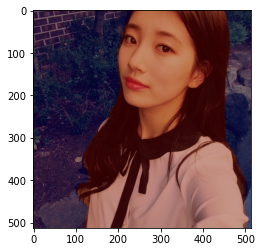

In [8]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

사람을 뜻하는 `15` 외 예측은 0으로 만들었다. 그럼 예측된 세그멘테이션 이미지(map)는 최대값이 15가 된다. 일반 이미지는 0부터 255 까지의 값을 사용해 픽셀을 표현하므로, 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화 한다. `applyColorMap()` 함수로 색을 적용하고 이미지를 화면에 출력한다.

#### 세그멘테이션 결과

<img src="./image/person_label.png" alt="Person Label" width="30%"/>

## 5. 셸로우 포커스 만들기 (4) 세그멘테이션 결과를 원래 크기로 복원하기
DeepLab 모델을 사용하기 위해 이미지 크기를 작게 resize 해서 입력했다. 따라서 출력도 resize 된 입력 크기와 같게 나오게 된다.

세그멘테이션 결과(mask)를 원래 크기로 복원해 보자.

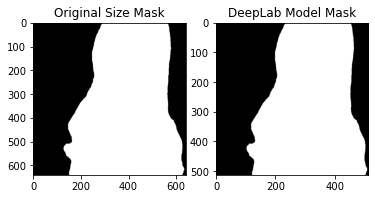

In [9]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

`cv2.resize()` 함수를 이용한다. 크기를 키울 때 보간(`interpolation`) 을 고려해야 하는데, `cv2.INTER_NEAREST`를 이용해서 깔끔하게 처리할 수 있지만 더 정확히 확대하기 위해 `cv2.INTER_LINEAR` 를 사용한다. 여기서 보간법(interpolation)은 이미지의 크기를 변경(scaling)하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법이다. 자세한 사항은 [opencv-python 문서](https://opencv-python.readthedocs.io/en/latest/doc/10.imageTransformation/imageTransformation.html)를 참고.

결과적으로 `img_mask_up` 은 경계가 블러된 픽셀값 0~255의 이미지를 얻는다. 확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(`threshold`)을 설정한다. 128 이하의 값은 0으로 128 이상의 값은 255로 만드는 방법이다.

### 결과
---
아래 두 이미지의 좌표축 부분에 집중해보자.

<img src="./image/mask_up.png" alt="Mask up" width="50%"/>

좌표를 통해 이미지의 크기가 다른 것을 확인할 수 있다.

## 6. 셸로우 포커스 만들기 (5) 배경 흐리게 하기
이번에는 배경을 흐리게 하기 위해서 세그멘테이션 마스크를 이용해서 배경만 추출하겠다.

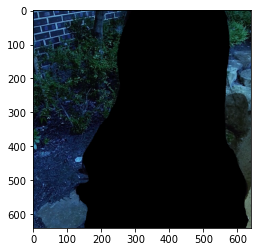

In [10]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)
plt.imshow(img_bg)
plt.show()

`bitwise_not` 함수를 이용하면 이미지가 반전된다. 배경은 255 사람은 0이 될 것이다. 반전된 세그멘테이션 결과를 이용해서 이미지와 `bitwise_and` 연산을 수행하면 배경만 있는 영상을 얻을 수 있다.

참고: [StackOverflow: `bitwise_not`, `bitwise_and`함수를 사용해 이미지 바꾸기](https://stackoverflow.com/questions/32774956/explain-arguments-meaning-in-res-cv2-bitwise-andimg-img-mask-mask)

__img_bg 이미지__

<img src="./image/bitwise.png" alt="bitwise" width="30%"/>

이 이미지를 블러(`blur`)하면 배경이 흐리게 처리된 영상을 얻을 수 있다.

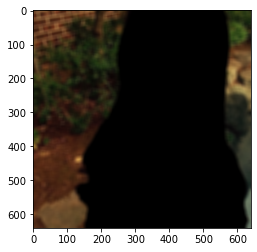

In [11]:
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

__imgbgblur 결과__

<img src="./image/blur.png" alt="blur" width="30%"/>

## 7. 셸로우 포커스 만들기 (6) 흐린 배경과 원본 영상 합성
이제 배경 영상과 사람 영상을 합치기만 하면 된다.

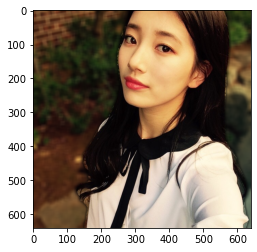

In [12]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

세그멘테이션 마스크가 255인 부분만 원본 영상을 가지고 오고 반대인 영역은 블러된 미지 값을 사용한다.

* 참고: [numpy.where() 사용법](https://numpy.org/doc/stable/reference/generated/numpy.where.html)

짠~!

<img src="./image/final.png" alt="Final" width="30%"/>

인물모드가 완성 되었다. 원본과 비교해 볼까?

<img src="./image/compare.jpg" alt="Compare" width="70%"/>

멋진 인물 사진이 만들어졌다.

인물과 배경의 거리차이가 있고 거리가 일정할 수록 더 자연스러워 보인다.